# Setup

### Label detection and model training

In [ ]:
## https://colab.research.google.com/drive/1tIDstIveN3tV-qX1qJGKkfjQRRg6L4vH?authuser=0#scrollTo=t5QM9-nAW1Uo

### Install packages

In [ ]:
!pip install ultralytics
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 379.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

### Import dataset from Roboflow (mainly use the test set)

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="SQ5v42zcXLanpi42oomz")
# project = rf.workspace("cargo-zgvsz").project("cargo-ilrb0")
# version = project.version(12)
# dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cargo-12 in yolov9:: 100%|██████████| 926/926 [00:00<00:00, 6560.85it/s]


### Upload the best weights file and set path

In [ ]:
# SET path variable for the best weights files
best_weights_path = '/content/best.pt'

# Get Images

### Test images

In [ ]:
# SET path variable for the test images
test_images_path = "/content/5455.jpeg"

### Camera Capture image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 640;
      canvas.height = 640;
      const ctx = canvas.getContext('2d');

      // Calculate scaling factors to stretch the image
      const videoWidth = video.videoWidth;
      const videoHeight = video.videoHeight;
      const scaleX = 640 / videoWidth;
      const scaleY = 640 / videoHeight;
      const scale = Math.max(scaleX, scaleY);

      // Calculate the position to center the stretched image on the canvas
      const newWidth = videoWidth * scale;
      const newHeight = videoHeight * scale;
      const offsetX = (640 - newWidth) / 2;
      const offsetY = (640 - newHeight) / 2;

      ctx.drawImage(video, 0, 0, videoWidth, videoHeight, offsetX, offsetY, newWidth, newHeight);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to camera/prediction-photo.jpg


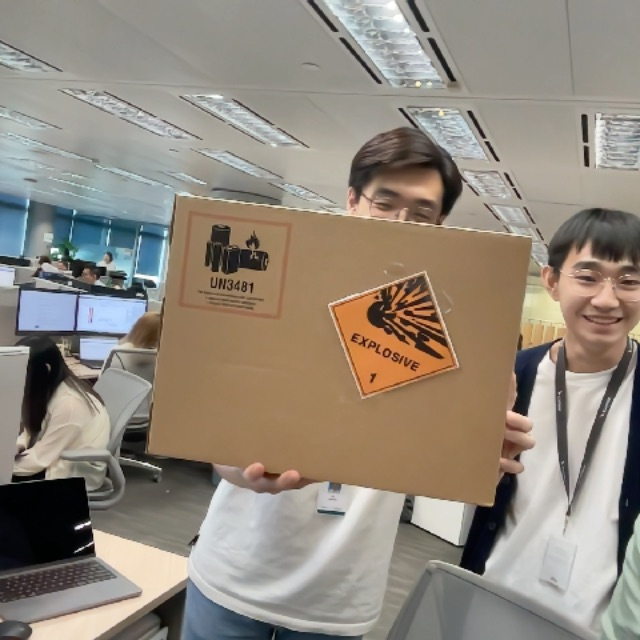

In [ ]:
from IPython.display import Image
import os
directory = '/content/camera'
if not os.path.exists(directory):
  os.mkdir(directory)
test_images_path = directory
try:
  filename = take_photo(filename='camera/prediction-photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Prediction on images


In [ ]:
from ultralytics import YOLO

best_model = YOLO(best_weights_path)
results = best_model.predict(test_images_path, imgsz=640, conf=0.3, save=True, show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/5455.jpeg: 480x640 3 UN_Logos, 1 class_3, 1 class_4, 1 class_5, 3 goodss, 1 this_way_up, 108.0ms
Speed: 12.0ms preprocess, 108.0ms inference, 838.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


Define DetectedObject class

In [ ]:
class DetectedObject:
  def __init__(self, cls, confidence, bounding_box, bounding_box_xywh):
    assert len(bounding_box) == 4
    self.cls = int(cls)
    self.confidence = float(confidence)
    self.bounding_box = bounding_box # In xyxy format
    self.bounding_box_xywh = bounding_box_xywh # In xywh format
    self.contained_objects = []

  def completely_contains(self, other):
    x1, y1, x2, y2 = self.bounding_box
    otherx1, othery1, otherx2, othery2 = other.bounding_box
    return (x1 < otherx1 and x2 > otherx2 and y1 < othery1 and y2 > othery2)

  def partially_contains(self, other):
    x1, y1, x2, y2 = self.bounding_box
    otherx1, othery1, otherx2, othery2 = other.bounding_box
    return not (otherx2 < x1 or otherx1 > x2 or othery2 < y1 or othery1 > y2)

  def contains(self, other):
    # select your strategy here
    return self.partially_contains(other)

  def validate(self):
    if self.cls != 12: #not goods
      return True
    # current logic: if UN number exists but no DG label, not valid
    contains_un = any({True if obj.cls in [0,1] else False for obj in self.contained_objects})
    contains_dg = any({True if obj.cls in [3,4,5,6,7,8,9,10,11] else False for obj in self.contained_objects})
    return not contains_un or contains_dg

Ths function initialises all DetectedObjects for a given image (Results object.)

In [ ]:
# resultObj is an image
def get_DetectedObject_from_image(resultObj):
  boxes = resultObj.boxes
  classes = boxes.cls.tolist()
  confidences = boxes.conf.tolist()
  bounding_boxes = boxes.xyxy.tolist()
  bounding_boxes_xywh = boxes.xywh.tolist()

  try:
    assert(len(classes) == len(confidences) == len(bounding_boxes))
  except AssertionError:
    print('List lengths do not match')

  non_goods_objects = []
  goods_objects = []
  for i in range(len(classes)):
    cls = classes[i]
    obj = DetectedObject(cls, confidences[i], bounding_boxes[i], bounding_boxes_xywh[i])
    if cls == 12: # goods
      goods_objects.append(obj)
    else:
      non_goods_objects.append(obj)

  for good in goods_objects:
    for non_good in non_goods_objects:
      if good.contains(non_good):
        good.contained_objects.append(non_good)

  return non_goods_objects, goods_objects

This function plots the goods_objects and non_goods_objects for a given image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def get_box_color(valid):
  if valid == True:
    return 'g'
  return 'r'

def get_textbox(valid):
  return 'valid' if valid else 'invalid'

def print_validation_results(goods_objects):
  for good in goods_objects:
    if good.validate():
      print(f'Good at {good.bounding_box_xywh} passed')
    else:
      print(f'Good at {good.bounding_box_xywh} did not pass')


def plot_goods_bounding_boxes_for_image(image_path, non_goods_objects, goods_objects):
  im = Image.open(image_path)
  fig, ax = plt.subplots()
  ax.imshow(im)

  # Plots boxes for "goods"
  for good in goods_objects:
    xywh = good.bounding_box_xywh

    # Adjustment for using patches.Rectangle
    xywh[0] -= xywh[2]/2
    xywh[1] -= xywh[3]/2

    validation = good.validate()
    box_color = get_box_color(validation)
    rect = patches.Rectangle((xywh[0], xywh[1]), xywh[2], xywh[3], linewidth=4, edgecolor=box_color, facecolor='none')
    ax.add_patch(rect)

    valid_text = get_textbox(validation)
    ax.text(xywh[0], xywh[1] - 10, valid_text, fontsize=12, color=box_color, verticalalignment='bottom')

  # Plots boxes for "UN" and "danger_label"
  for good in non_goods_objects:
    xywh = good.bounding_box_xywh

    # Adjustment for using patches.Rectangle
    xywh[0] -= xywh[2]/2
    xywh[1] -= xywh[3]/2

    rect = None



    if good.cls in [0,1]: # UN
      rect = patches.Rectangle((xywh[0], xywh[1]), xywh[2], xywh[3], linewidth=2, edgecolor="black", facecolor='none')
    if good.cls in [3,4,5,6,7,8,9,10,11]: # DG
      rect = patches.Rectangle((xywh[0], xywh[1]), xywh[2], xywh[3], linewidth=2, edgecolor="blue", facecolor='none')
    if good.cls in [2,12,13,14]: # DG
      rect = patches.Rectangle((xywh[0], xywh[1]), xywh[2], xywh[3], linewidth=2, edgecolor="yellow", facecolor='none')

    if (rect):
      ax.add_patch(rect)

  plt.axis('off')
  plt.show()

  return True


Image 1


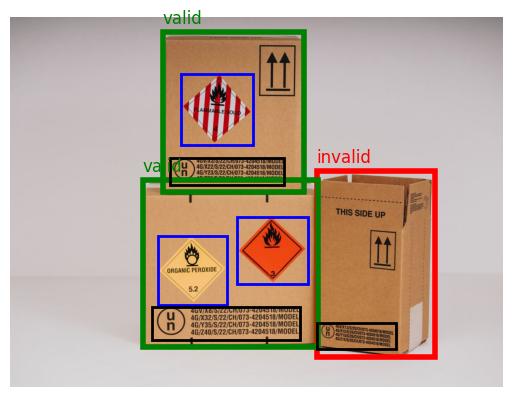

Good at [684.3109436035156, 343.38795471191406, 264.17010498046875, 413.0782165527344] did not pass
Good at [295.6861114501953, 363.0471496582031, 390.8184509277344, 373.15032958984375] passed
Good at [340.69444274902344, 32.30474853515625, 315.4422912597656, 357.3232116699219] passed


In [ ]:
count = 0
# Loop through each image
for resultObj in results:
  # Counter
  count+=1
  print("Image "+str(count))

  # Init all DetectedObject(s) in an image
  non_goods_objects, goods_objects = get_DetectedObject_from_image(resultObj)

  # Plot all images with the bounding boxes
  plot_goods_bounding_boxes_for_image(resultObj.path ,non_goods_objects, goods_objects)

  # For debug if needed
  print_validation_results(goods_objects)

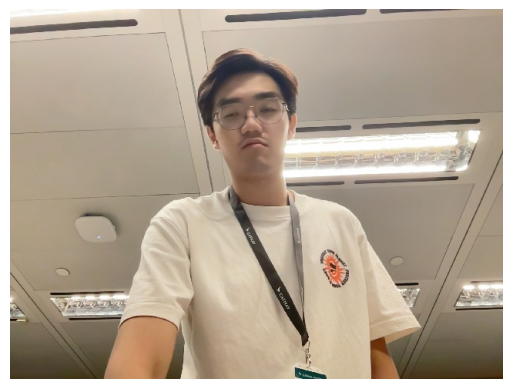

<IPython.core.display.Javascript object>


0: 480x640 (no detections), 40.0ms
Speed: 1.5ms preprocess, 40.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 2 danger_labels, 39.4ms
Speed: 1.9ms preprocess, 39.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 danger_label, 39.5ms
Speed: 2.3ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.9ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 2.9ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.9ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 2.5ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 danger_label, 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.9ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 3.7ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 danger_label, 39.4ms
Speed: 2.0ms preprocess, 39.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 danger_label, 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 2.5ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 39.4ms
Speed: 2.2ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>

Stopped


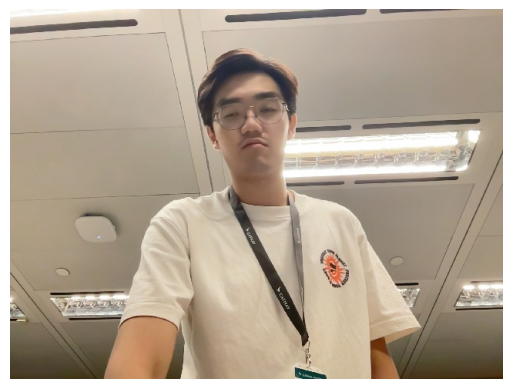

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from PIL import Image
import io
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to capture video frames and run YOLO detection
def video_stream():
    js = Javascript('''
        async function streamVideo() {
            const video = document.createElement('video');
            video.style.display = 'none';  // Hide the raw video feed
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Capture video frame every 100ms and return as base64 encoded image
            const canvas = document.createElement('canvas');
            const ctx = canvas.getContext('2d');
            canvas.width = 640;
            canvas.height = 480;

            const capture = () => {
                ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
                return canvas.toDataURL('image/jpeg', 0.8);
            };
            return new Promise(resolve => {
                setInterval(() => {
                    resolve(capture());
                }, 100);
            });
        }
    ''')
    display(js)
    data = eval_js('streamVideo()')
    return data

# Load YOLO model
best_model = YOLO('/content/best-4.pt')  # Replace 'best.pt' with the path to your model

# Function to run inference on video frames
def run_inference():
    try:
        plt.ion()  # Turn on interactive mode in matplotlib
        fig, ax = plt.subplots()
        display_handle = display(fig, display_id=True)

        while True:
            # Capture frame from video stream
            img_data = video_stream()
            img = Image.open(io.BytesIO(b64decode(img_data.split(',')[1])))
            img_np = np.array(img)

            # Run YOLO model
            results = best_model.predict(img_np, imgsz=640, conf=0.3)

            # Process results and draw bounding boxes
            for result in results:
                non_goods_objects, goods_objects = get_DetectedObject_from_image(result)
                img_np = draw_bounding_boxes(img_np, non_goods_objects, goods_objects)

            # Update the plot with the new frame
            ax.clear()
            ax.imshow(img_np)
            plt.axis('off')
            display_handle.update(fig)

    except KeyboardInterrupt:
        print("Stopped")

# Function to draw bounding boxes
def draw_bounding_boxes(image, non_goods_objects, goods_objects):
    # Draw boxes directly on the numpy image
    for good in goods_objects:
        xywh = good.bounding_box_xywh
        xywh[0] -= xywh[2] / 2
        xywh[1] -= xywh[3] / 2

        validation = good.validate()
        box_color = get_box_color(validation)
        cv2.rectangle(image, (int(xywh[0]), int(xywh[1])),
                      (int(xywh[0] + xywh[2]), int(xywh[1] + xywh[3])),
                      box_color, 4)
        valid_text = get_textbox(validation)
        cv2.putText(image, valid_text, (int(xywh[0]), int(xywh[1] - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, box_color, 2)

    # Draw boxes for UN and danger labels
    for non_good in non_goods_objects:
        xywh = non_good.bounding_box_xywh
        xywh[0] -= xywh[2] / 2
        xywh[1] -= xywh[3] / 2
        color = (0, 0, 0) if non_good.cls == 2 else (255, 0, 0)
        cv2.rectangle(image, (int(xywh[0]), int(xywh[1])),
                      (int(xywh[0] + xywh[2]), int(xywh[1] + xywh[3])),
                      color, 2)

    return image

# Start the video stream and inference
run_inference()
